# Group objects that behave in a similar way
### Assets that behave/trade in a similar way
- Volitility
- Price Return Behavior

In [101]:
# Silence Warnings
import warnings 
warnings.simplefilter(action="ignore" , category=FutureWarning)

In [102]:
# Fetch/Structure Data
import numpy as np 
import pandas as pd
import yfinance as yf
import pandas_datareader.nasdaq_trader as pdr


# Feature Engineering
from sklearn.preprocessing import  StandardScaler

# Machine Learning
from sklearn.cluster import  KMeans
from sklearn import metrics

# The knee point is the point of maximum curvature.
from kneed import KneeLocator

# Co-Integration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data Extraction

In [103]:
# Data Storage
filename = "data-storage/raw_data_etf.csv"
filename_co_integration = "data-storage/raw_data_conint_pairs.csv"

In [104]:
# Load Saved Data or Fetch
load_existing = False
load_coint_pairs = False

In [105]:
# Time Range
start_date = "2023-01-01"
end_date = "2023-07-13"

### Fetch Data

In [106]:
#  Get New Data
if not load_existing:
    symbols = pdr.get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True)  &  (symbols["Market Category"] == "G")] #global markets
    symbols = list(symbols.index.values)
    
    # # create dataframe with all etf stocks data
    fetched_stocks = []
    for symbol in symbols:
        data = yf.download(symbol ,  start_date , end_date )
        data = data[["Open" , "High" , "Low" , "Close" ]].copy()
        data["Symbol"] = symbol
        fetched_stocks.append(data)
    
    # Save Data
    df = pd.concat(fetched_stocks)
    df.reset_index(inplace=True)
    df = df.pivot(index='Date', columns='Symbol', values='Close')
    df.to_csv(filename)




# READ FILE
else:
    df = pd.read_csv(filename)

# Condition Data

In [107]:

# Drop Null Values
if df.isnull().values.any():
    df = df.dropna(axis=1)
    df = df.set_index("Date")

print("Shape: " , df.shape)
df.head()

Shape:  (131, 488)


AADR    AAPB       AAPD       AAPU       AAXJ       ACWI  \
Date                                                                        
2023-01-03  47.189999  14.440  31.400000  15.730000  65.669998  84.900002   
2023-01-04  47.529999  14.641  31.084000  15.980000  67.919998  85.980003   
2023-01-05  47.340000  14.413  31.389999  15.720000  67.559998  85.099998   
2023-01-06  48.099998  15.295  30.301001  16.549999  68.769997  87.070000   
2023-01-09  48.290001  15.430  30.120001  16.670000  69.290001  87.260002   

                 ACWX       AGNG       AGZD        AIA  ...   WGMI       WGRO  \
Date                                                    ...                     
2023-01-03  45.799999  26.299999  43.369999  57.820000  ...  4.559  19.841999   
2023-01-04  46.700001  26.531000  43.480000  60.990002  ...  5.097  19.907000   
2023-01-05  46.299999  26.389999  43.540001  60.680000  ...  5.240  19.834999   
2023-01-06  47.389999  26.916000  43.509998  61.730000  ...  5.210  20.400000   
2023-01-09  47.619999  26.639999  43.570000  62.480000  ...  5.850  20.309000   

                 WINC        WIZ       WNDY       WOOD       WRND    XDNA  \
Date                                                                        
2023-01-03  23.455000  27.530001  18.299999  73.000000  20.034000   9.880   
2023-01-04  23.510000  27.778000  18.360001  74.010002  20.379000  10.460   
2023-01-05  23.490000  27.621000  18.160000  73.470001  20.180000  10.510   
2023-01-06  23.660000  27.849001  18.719999  75.419998  20.690001  10.440   
2023-01-09  23.690001  27.900000  18.780001  75.830002  20.747999  10.149   

                   XT       YLDE  
Date                              
2023-01-03  47.430000  38.973999  
2023-01-04  48.349998  39.320999  
2023-01-05  47.490002  38.854000  
2023-01-06  48.490002  39.792000  
2023-01-09  49.080002  39.726002  

[5 rows x 488 columns]

# Feature Engineering
- For Each ETF stock
    - average returns
    - average volitility


In [108]:
# Create Dataframe with Returns and Volitility for each stock

df_returns = pd.DataFrame(df.pct_change().mean() * 255 , columns=["Returns"])
df_returns["Volitility"] = df.pct_change().std() * np.sqrt(255)


df_returns

Returns  Volitility
AADR  0.130146    0.178680
AAPB  1.377171    0.354795
AAPD -0.809714    0.207162
AAPU  1.191495    0.310739
AAXJ  0.090865    0.172133
...        ...         ...
WOOD  0.043101    0.175989
WRND  0.465019    0.154989
XDNA  0.017863    0.348349
XT    0.371243    0.199695
YLDE  0.172663    0.127340

[488 rows x 2 columns]

### Scaling Dataframe
- To make sure if one column ranges from 1 to 10 and another column ranges from 1000 to 10000

In [109]:
# Scaling Features
scaler = StandardScaler()

# Transform Values to propper scale size
scaler = scaler.fit_transform(df_returns)

# make a new dataframe using the scaled values
scaled_data = pd.DataFrame(scaler , columns=df_returns.columns , index=df_returns.index)
df_scaled = scaled_data


df_scaled

Returns  Volitility
AADR -0.141791   -0.068956
AAPB  2.332870    1.117865
AAPD -2.006898    0.122980
AAPU  1.964405    0.820975
AAXJ -0.219742   -0.113078
...        ...         ...
WOOD -0.314527   -0.087091
WRND  0.522749   -0.228614
XDNA -0.364610    1.074423
XT    0.336654    0.072662
YLDE -0.057416   -0.414937

[488 rows x 2 columns]

# K MEANS CLUSTERING

### Obtain Optimal Amount of Clusters
- how many clusters until the inertia dramatically decreases?

In [110]:
# Make a copy of your scaled dataframe
x = df_scaled.copy()

# Define amount of clusters
k = range(1,16,1)

# Create an empty list where we'll store the sum of squared distances
# (known as inertia) for each number of clusters
distortions = []

# Loop through each number of clusters in our range
for calc in k:
    # Create a KMeans model with the current number of clusters
    kmeans = KMeans(n_clusters=calc)
    
    # Fit the KMeans model to our data
    kmeans.fit(x)
    
    # Calculate the model's inertia (sum of squared distances to closest cluster)
    distortions.append(kmeans.inertia_)

# Use the KneeLocator function to find the "elbow point" in our range of clusters
# The elbow point is the number of clusters at which adding more clusters 
# does not significantly decrease the inertia (sum of squared distances).
# In this case, the function is looking for a point where the curve of the 
# distortions plot is convex and decreasing.
k1 = KneeLocator(k , distortions , curve="convex" , direction="decreasing")

# The elbow point (optimum number of clusters) is stored in `c`
Optimal_Amount_Clusters = k1.elbow

# Print out the optimum number of clusters
print("Optimum Clusters" , Optimal_Amount_Clusters)


Optimum Clusters 4


### Fit AI knn Model

In [111]:
# fit
k_means = KMeans(n_clusters=Optimal_Amount_Clusters)
k_means.fit(x)

KMeans(n_clusters=4)

In [112]:
# predict
prediction = k_means.predict(df_scaled)

# Display Results

<function matplotlib.pyplot.show(close=None, block=None)>

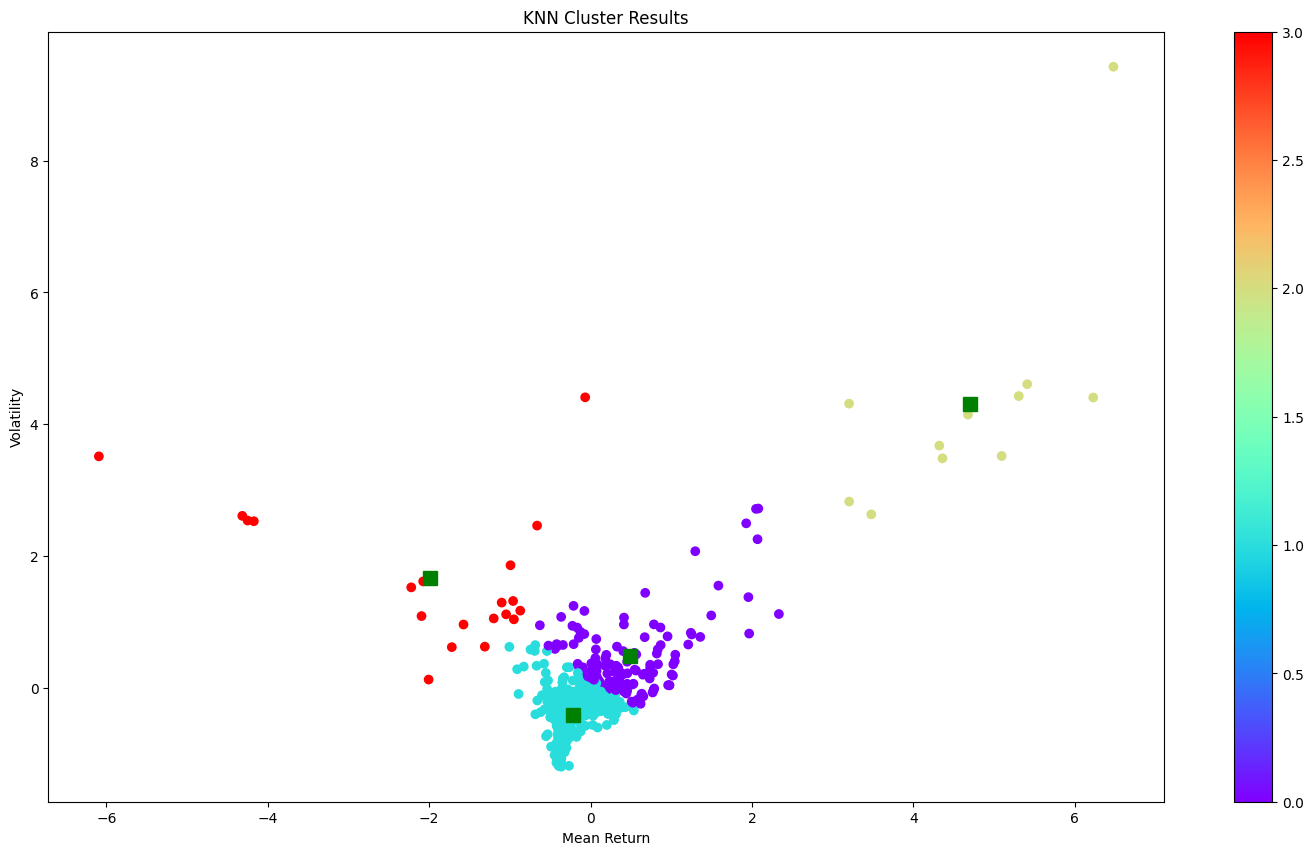

In [113]:
# Obtain the centroids of the clusters from the trained KMeans model.
centroids = k_means.cluster_centers_

# Create a figure to host the plot, with size 18x10.
fig = plt.figure(figsize=(18,10))

# Add a subplot to the figure.
Graphic = fig.add_subplot(111)

# Scatter plot of the data, colored by cluster label.
scatter = Graphic.scatter(x.iloc[:,0], x.iloc[:,1] , c = k_means.labels_, cmap="rainbow" , label=x.index)

# Set the title and labels for the axes of the plot.
Graphic.set_title("KNN Cluster Results")
Graphic.set_xlabel("Mean Return")
Graphic.set_ylabel("Volatility")

# Display a color bar to illustrate which color corresponds to which cluster.
plt.colorbar(scatter)

# Plot the centroids of each cluster as green squares.
plt.plot(centroids[:,0] , centroids[:,1] , "sg" , markersize = 10)
plt.show


In [114]:
# Return Series
clustered_series = pd.Series(index=x.index , data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=x.index , data=k_means.labels_.flatten())

# Remove outliers, denoted by -1, from the series
clustered_series = clustered_series[clustered_series != -1]


clustered_series[:15]

AADR    1
AAPB    0
AAPD    3
AAPU    0
AAXJ    1
ACWI    1
ACWX    1
AGNG    1
AGZD    1
AIA     0
AIQ     0
AIRR    0
ALTY    1
AMID    0
AMZD    3
dtype: int32

Text(0.5, 0, 'Cluster')

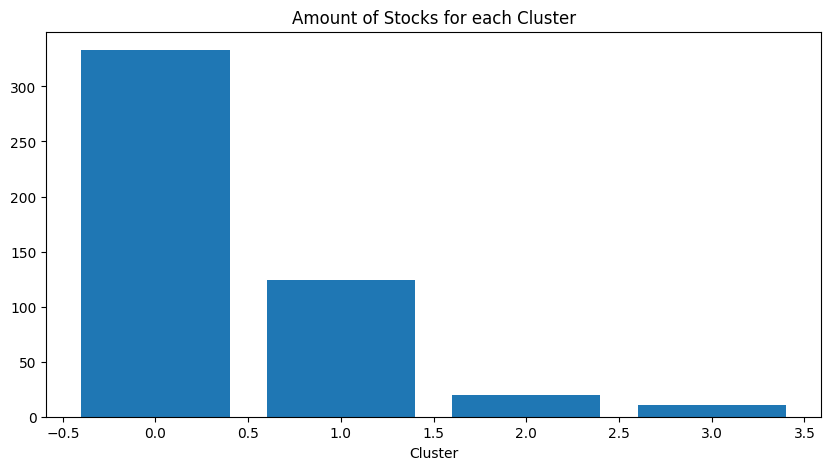

In [129]:
# view number by cluser
plt.figure(figsize=(10,5))

# Generate a bar chart. X-axis is the range of the number of unique clusters. Y-axis is the count of items in each cluster.
plt.bar(range(len(clustered_series.value_counts())) , clustered_series.value_counts())

# Labels
plt.title("Amount of Stocks for each Cluster")
plt.xlabel("Cluster")

In [116]:
# Remove Clusters if preferred
clusters_clean = clustered_series[clustered_series < 3]

print(f"Current Clusters: {len(clustered_series)}")
print(f"Cleaned Clusters: {len(clusters_clean)}")

Current Clusters: 488
Cleaned Clusters: 468


# FIND Cointergrated Stock Pairs (linear-cointergration)
- OLS regression

In [117]:
def calc_cointergration(series_1 , series_2):
    # Initialize flag
    coint_flag = 0
    
    # Perform the Augmented Dickey-Fuller test to check for stationarity
    coint_res = coint(series_1 , series_2)
    
    # Extract t-statistic, p-value and critical values from the test results
    count_t = coint_res[0]
    p_value = coint_res[1]
    critical_val = coint_res[2][1]
    
    # Perform Ordinary Least Squares (OLS) regression to find the hedge ratio
    model = sm.OLS(series_1,series_2).fit()
    hedge_ratio = model.params[0]
    
    # If p-value is less than 0.05 (5% significance level) and t-statistic is less than critical value
    # it means the two series are cointegrated and we set the flag to 1
    coint_flag = 1 if p_value < 0.05 and count_t < critical_val else 0

    return coint_flag , hedge_ratio


- goes through a list of asset pairs
- checks if they belong to the same cluster
- if they are not the same asset. Then, it checks if these pairs of assets are cointegrated
    - meaning they move together over time, and appends the cointegrated pairs to a list.

In [118]:
# Initialize two lists: one for storing tested asset pairs, another for storing cointegrated asset pairs.
tested_pairs = []
cointergrated_pairs = []


if not load_coint_pairs:

    # FIND ALL COINTERGRATIONS
    for base_asset in clusters_clean.index:
        
        # BASE CLUSTER NUMBER
        base_label = clusters_clean[base_asset]

        # COMPARE AGAINST EVERY OTHER TICKER
        for compare_asset in clusters_clean.index:
            
            # COMPARISON CLUSTER NUMBER
            compare_label = clusters_clean[compare_asset]

            # CREATE PAIR STRING FOR REFERENCE & SORT
            test_pair = base_asset + compare_asset
            test_pair = "".join(sorted(test_pair))
            
            # CHECK IF TESTED ALREADY
            is_tested = test_pair in tested_pairs
            tested_pairs.append(test_pair)

            # CHECK IF BELONG TO SAME CLUSTER
            if compare_asset != base_asset and base_label == compare_label and not is_tested:
                
                # FETCH THEIR DATA
                series_1 = df[base_asset].values.astype(float)
                series_2 = df[compare_asset].values.astype(float)
                
                # FIND OUT IF COINTERGRATED OR NOT
                coint_flag , _ = calc_cointergration(series_1,series_2)
                
                if coint_flag == 1:
                    # Add this pair of assets to the list of cointegrated pairs.
                    cointergrated_pairs.append({
                        "base_asset":base_asset,
                        "compare_asset":compare_asset,
                        "label":base_label
                    })

                    print(f"{test_pair.strip()}\t | {_} | {base_label}" )


    df_coint = pd.DataFrame(cointergrated_pairs).sort_values(by="label")
    df_coint.to_csv(filename_co_integration)

AABDJORS	 | 2.1587487432604413 | 1
AAACDFR	 | 0.7007781778024706 | 1
AADDEGRR	 | 2.1444962272085606 | 1
AADDLORV	 | 1.8751923570381661 | 1
AAADFLNR	 | 1.928461909481088 | 1
AACDFRTV	 | 1.5130114947801443 | 1
AACDFRST	 | 0.6570955775948302 | 1
AADDHRYZ	 | 2.328471262330543 | 1
AADKPRW	 | 0.5579220006304821 | 1
AADDRRVY	 | 1.0578526418299778 | 1
AADDNRRV	 | 1.7072232267170704 | 1
AACDLNRR	 | 1.558958867133146 | 1
AACDMNRR	 | 1.7316054526721751 | 1
AADRSTVX	 | 1.9368812785285305 | 1
AADNORVV	 | 0.7156438463451685 | 1
AAADDRSV	 | 1.07291860786543 | 1
AABFMPSU	 | 0.7771750624474016 | 0
AABDDOPS	 | 1.1611959297001442 | 0
AADDOPSU	 | 1.195697085908367 | 0
AAAJLTXY	 | 5.959232502503304 | 1
AAAGJLNX	 | 2.4490657990052864 | 1
AABBHJX	 | 0.4205280154311619 | 1
AABJMNSX	 | 2.687441561325194 | 1
AACDJLX	 | 1.1674109825505392 | 1
AACFJOX	 | 1.0836187158219095 | 1
AACCJLSX	 | 3.4859069564567773 | 1
AACJMOTX	 | 2.51947866132615 | 1
AACFJSX	 | 1.276988328270552 | 1
AACDEJOX	 | 5.734699165956933 | 1
AAB

In [119]:
# READ FILE
df_coint = pd.read_csv(filename_co_integration).iloc[:, 1:]

# TSNE DATA

In [120]:
# get unique cointergrated assets
coin_assets = [df_coint["base_asset"].values]
coin_assets.append(df_coint["compare_asset"].values)
coin_unique_assets = np.unique(coin_assets)

coin_unique_assets

array(['AADR', 'AAPB', 'AAPU', 'AAXJ', 'ACWI', 'ACWX', 'AGNG', 'AGZD',
       'AIA', 'AIQ', 'ALTY', 'AMID', 'AMZU', 'ANGL', 'AOTG', 'AQWA',
       'ARVR', 'ASET', 'BBH', 'BFIT', 'BGRN', 'BJK', 'BLCN', 'BLLD',
       'BND', 'BNDW', 'BNDX', 'BOTZ', 'BRNY', 'BSCN', 'BSCO', 'BSCP',
       'BSCQ', 'BSCR', 'BSCS', 'BSCT', 'BSCU', 'BSCV', 'BSCW', 'BSJN',
       'BSJO', 'BSJP', 'BSJQ', 'BSJR', 'BSJS', 'BSJT', 'BSJU', 'BSMN',
       'BSMO', 'BSMP', 'BSMQ', 'BSMR', 'BSMS', 'BSMT', 'BSMU', 'BSMV',
       'BTEC', 'BTF', 'BUG', 'BULD', 'BYOB', 'CACG', 'CARZ', 'CATH',
       'CCSO', 'CDC', 'CDL', 'CEFA', 'CFA', 'CFO', 'CIBR', 'CID', 'CIL',
       'CIRC', 'CIZ', 'CLOU', 'CLRG', 'CLSA', 'CLSC', 'CLSM', 'CNCR',
       'COMT', 'COWG', 'CSA', 'CSB', 'CSF', 'CTEC', 'CXSE', 'DALI', 'DAX',
       'DDIV', 'DEMZ', 'DGRE', 'DGRS', 'DGRW', 'DMAT', 'DMXF', 'DRIV',
       'DVAL', 'DVLU', 'DVOL', 'DVY', 'DWAW', 'DWMC', 'DWSH', 'DWUS',
       'DXGE', 'DXJS', 'EBIZ', 'ECOW', 'EDOC', 'EDUT', 'EEMA', 'EFAS',
       'E

In [121]:
# Update df_TSNE to contain only the rows with cointergrated assets and their returns and volitility

df_TSNE = df_scaled.copy()
df_TSNE = df_TSNE[df_TSNE.index.isin(coin_unique_assets)]

df_TSNE

Returns  Volitility
AADR -0.141791   -0.068956
AAPB  2.332870    1.117865
AAPU  1.964405    0.820975
AAXJ -0.219742   -0.113078
ACWI  0.131022   -0.356314
...        ...         ...
WNDY -0.892609   -0.096216
WOOD -0.314527   -0.087091
WRND  0.522749   -0.228614
XDNA -0.364610    1.074423
YLDE -0.057416   -0.414937

[435 rows x 2 columns]

In [122]:
# Apply t-SNE transformation to df_TSNE with specific parameters
x_tsne = TSNE(learning_rate=30, perplexity=5,random_state=42, n_jobs=-1).fit_transform(df_TSNE)

x_tsne

array([[  6.087856  ,  -9.292674  ],
       [ 80.90896   ,   0.43400374],
       [ 80.34212   ,   0.8849322 ],
       [  1.8306986 , -13.367259  ],
       [  1.9836079 ,  44.935116  ],
       [ -7.6184382 ,  32.92733   ],
       [-22.506645  , -10.90304   ],
       [-42.769344  ,  19.728338  ],
       [ 24.478497  , -22.65844   ],
       [ 64.00455   ,  12.106306  ],
       [-40.615723  , -27.542965  ],
       [ 30.85566   ,   2.9912622 ],
       [ 83.95554   ,  -4.4048285 ],
       [-44.097153  , -12.3900795 ],
       [ 75.43604   ,   1.4962367 ],
       [  2.6214876 ,  28.221542  ],
       [ 55.80064   ,   2.6462357 ],
       [-18.863024  , -17.758152  ],
       [ -8.524748  , -40.18822   ],
       [  8.612602  ,  -5.0403786 ],
       [-51.95375   ,   6.711648  ],
       [ 40.661865  ,   0.2649233 ],
       [ 37.750195  , -26.749414  ],
       [ -7.4058685 ,  -3.1479125 ],
       [-57.804745  ,   0.96213156],
       [-52.827667  ,   5.881007  ],
       [-50.326824  ,   8.287695  ],
 

# Display TNSE
- this code is creating a map, where each point is an asset (stock). Assets that behave similarly are shown closer together. Lines between points mean those two assets have been found to move together based on a certain statistical test. The different colors represent different groups of assets that are found to be similar. The goal is to visualize how different assets relate to each other.

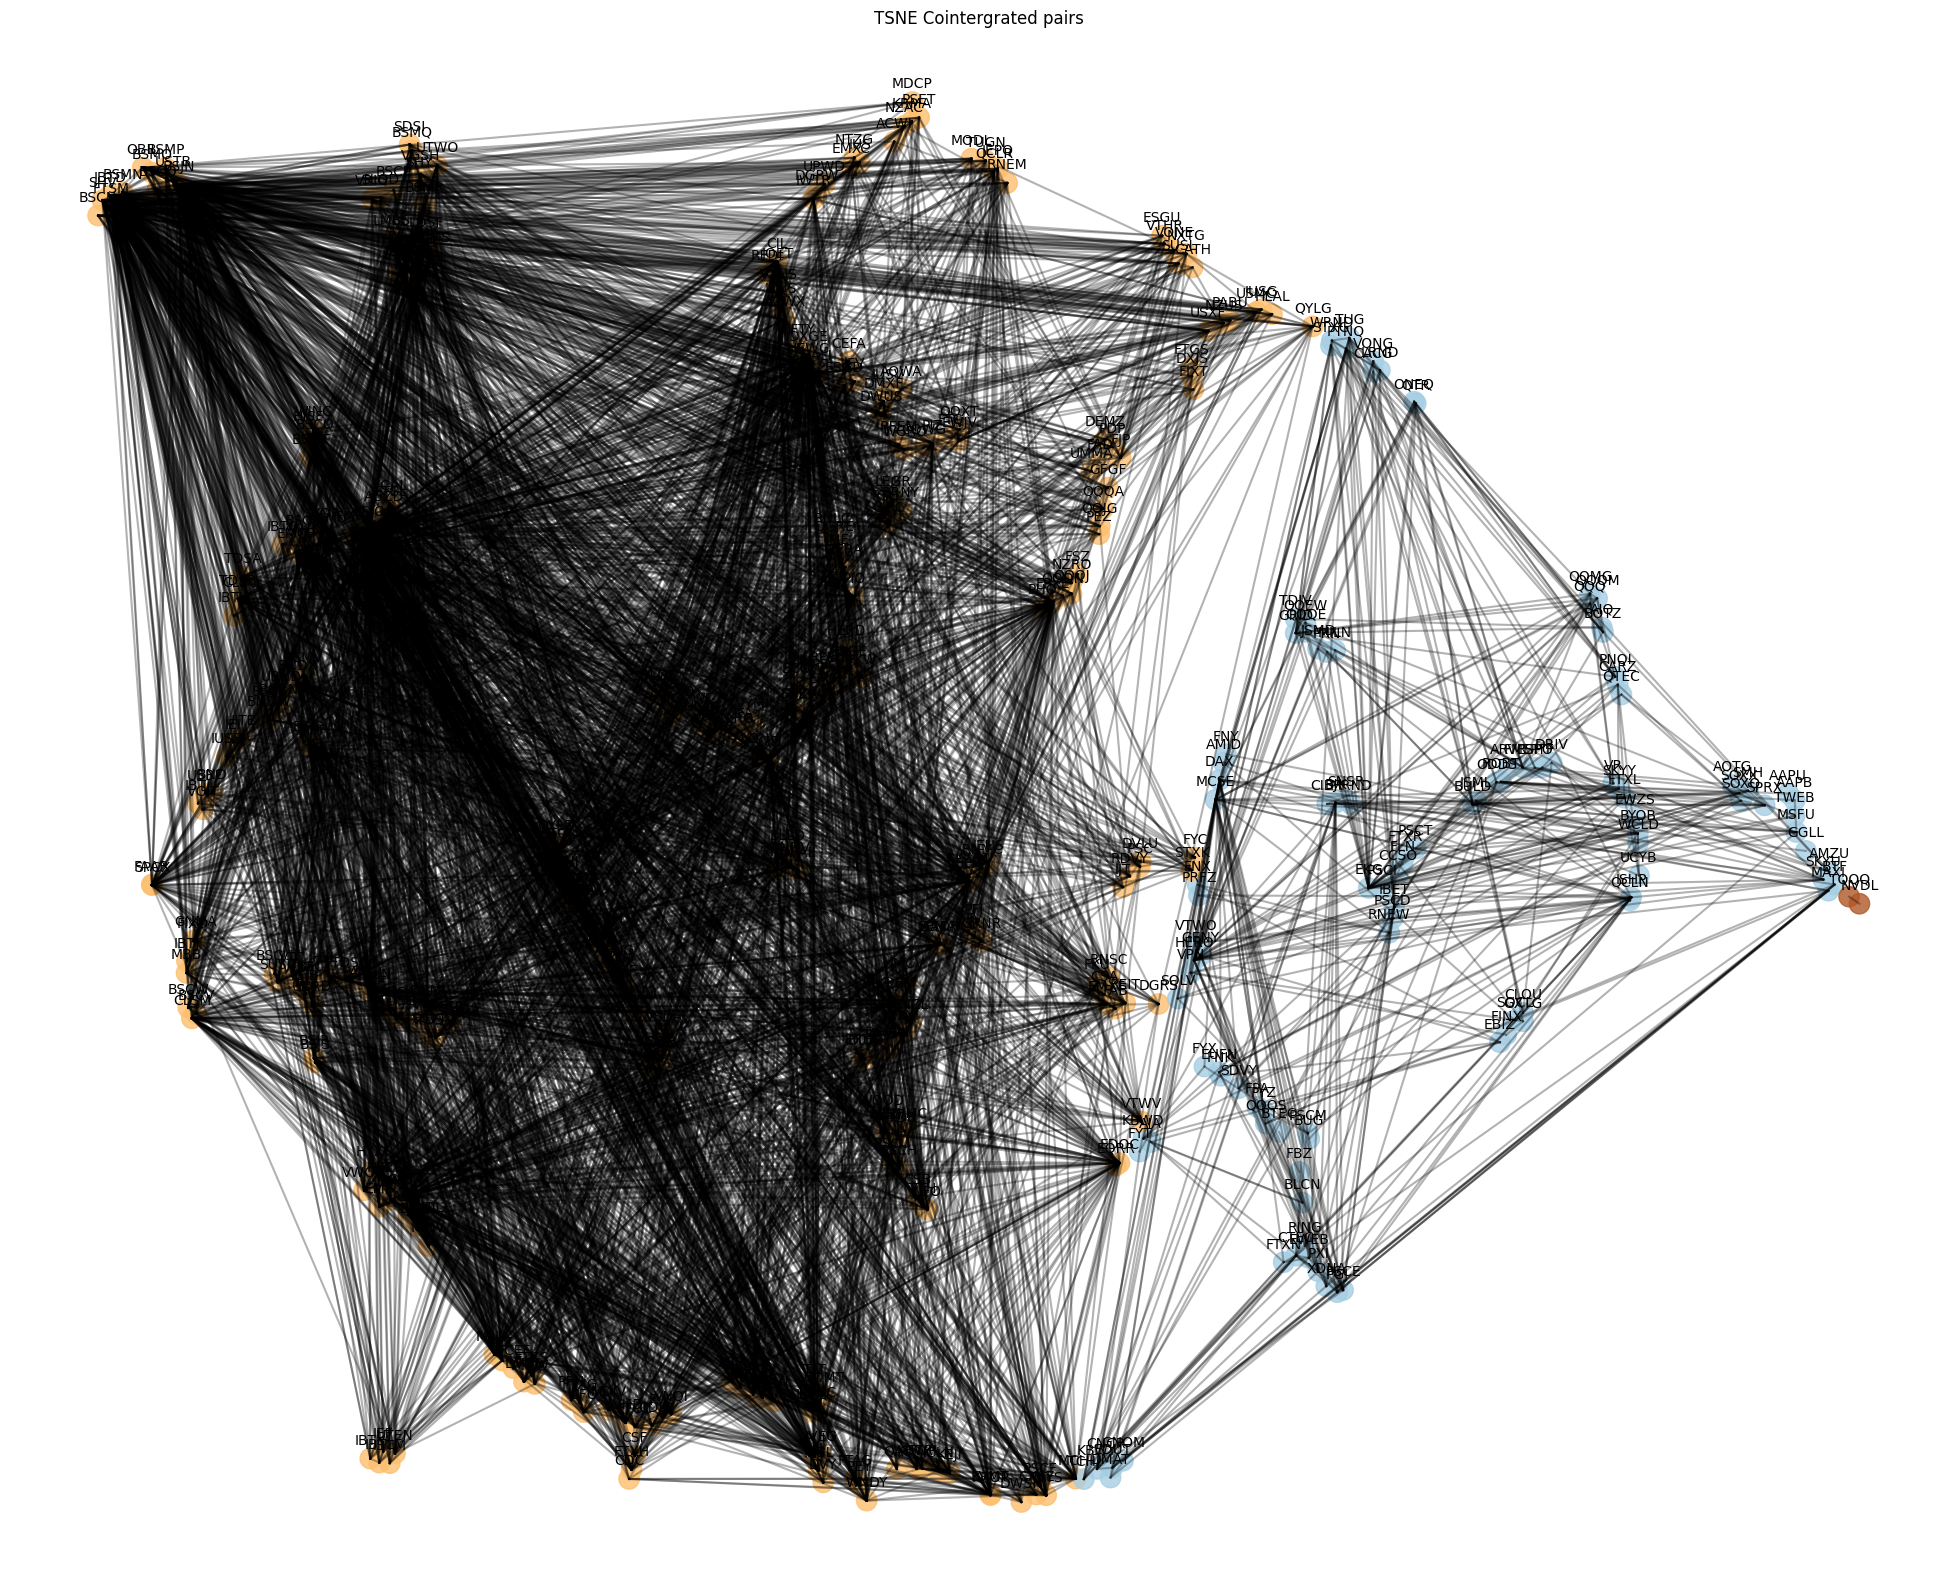

In [123]:
# Get series of clustered pairs
in_pairs_series = clustered_series.loc[coin_unique_assets]

# setup graphic figure
plt.figure(1,figsize=(25,20))
plt.clf()
plt.axis("off")


# Draw line for each pair in df_coint
for index , pair in df_coint.iterrows():
    ticker1 = pair[0]
    loc1 = df_TSNE.index.get_loc(pair[0])
    x1 , y1 = x_tsne[loc1, :]

    ticker2 = pair[1]
    loc2 = df_TSNE.index.get_loc(pair[1])
    x2 , y2 = x_tsne[loc2, :]
    plt.plot([x1,x2] , [y1,y2] , "k-" , alpha=0.3)


# Scatter plot with transformed data and color based on in_pairs_series
plt.scatter(x_tsne[:, 0] , x_tsne[: , 1] , s=215 , alpha=0.8 , c=in_pairs_series.values, cmap=cm.Paired )
plt.title("TSNE Cointergrated pairs")


# Add annotations for each point on the plot
for _x , _y , name in zip(x_tsne[:, 0] , x_tsne[:, 1] , df_TSNE.index):
    label = name
    plt.annotate(label , (_x,_y) , textcoords="offset points" , xytext=(0,10) , ha="center")

# final display
plt.show()

# ----------- Review a Pair's Price -----------

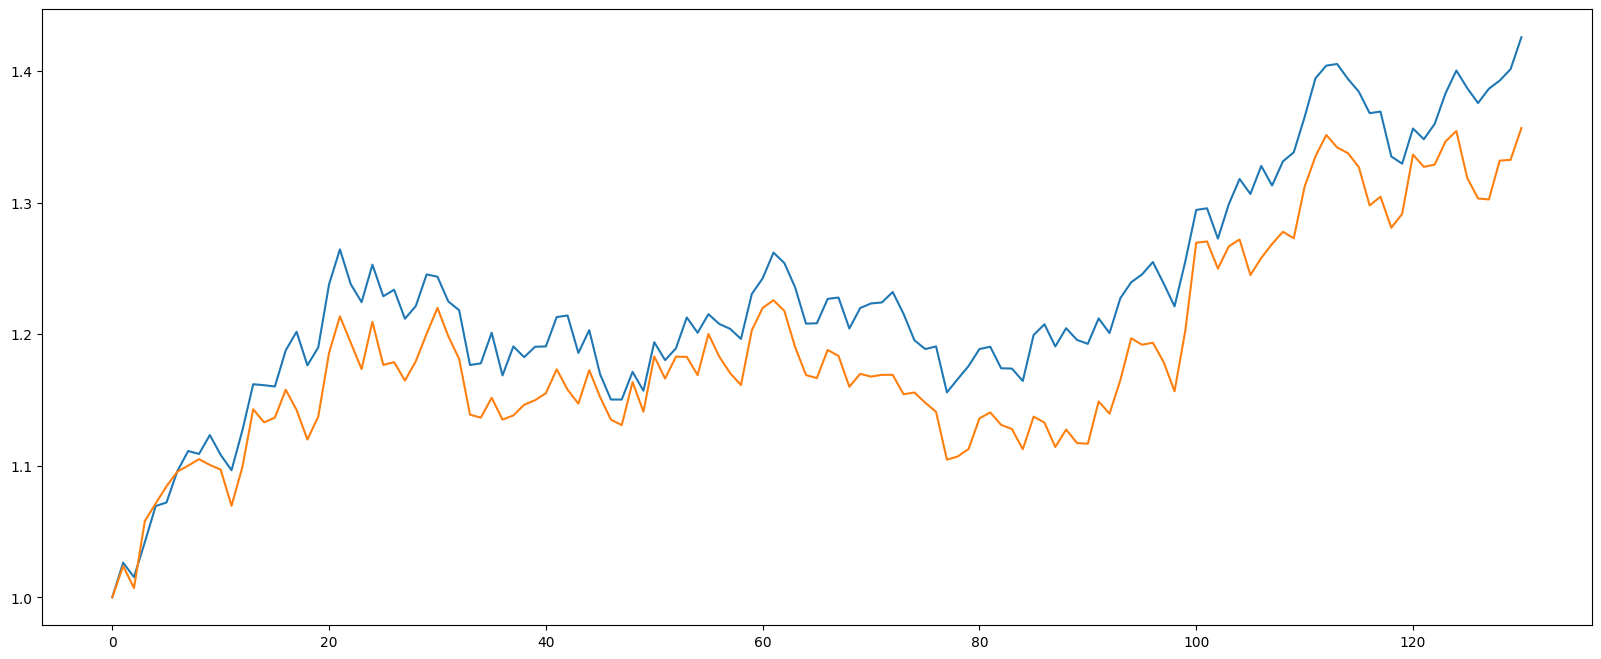

base_asset compare_asset  label
0          MAXI           PGJ      0
1          CTEC          DMAT      0
2          CTEC          EDUT      0
3          CTEC          EWEB      0
4          CTEC          FTXN      0
...         ...           ...    ...
5444       CEFA          EWJV      1
5445       CEFA          ESMV      1
5446       CEFA          NFTY      1
5447       VXUS          YLDE      1
5448       NVDL          TQQQ      2

[5449 rows x 3 columns]

In [124]:
# Plot price comparison for any given asset
asset_1 = "CARZ"
asset_2 = "FTXL"

asset_1_values =  df[asset_1].values / df[asset_1].iloc[0].item()
asset_2_values = df[asset_2].values / df[asset_2].iloc[0].item()

plt.figure( 1 , figsize=(20,8))
plt.plot(asset_1_values)
plt.plot(asset_2_values)
plt.show()


# Co-Intergrated Stocks
df_coint

# Review a Pair's Spread
- STOCK1 - STOCK2 * hedge ratio
- you want it to be as close to zero as possible

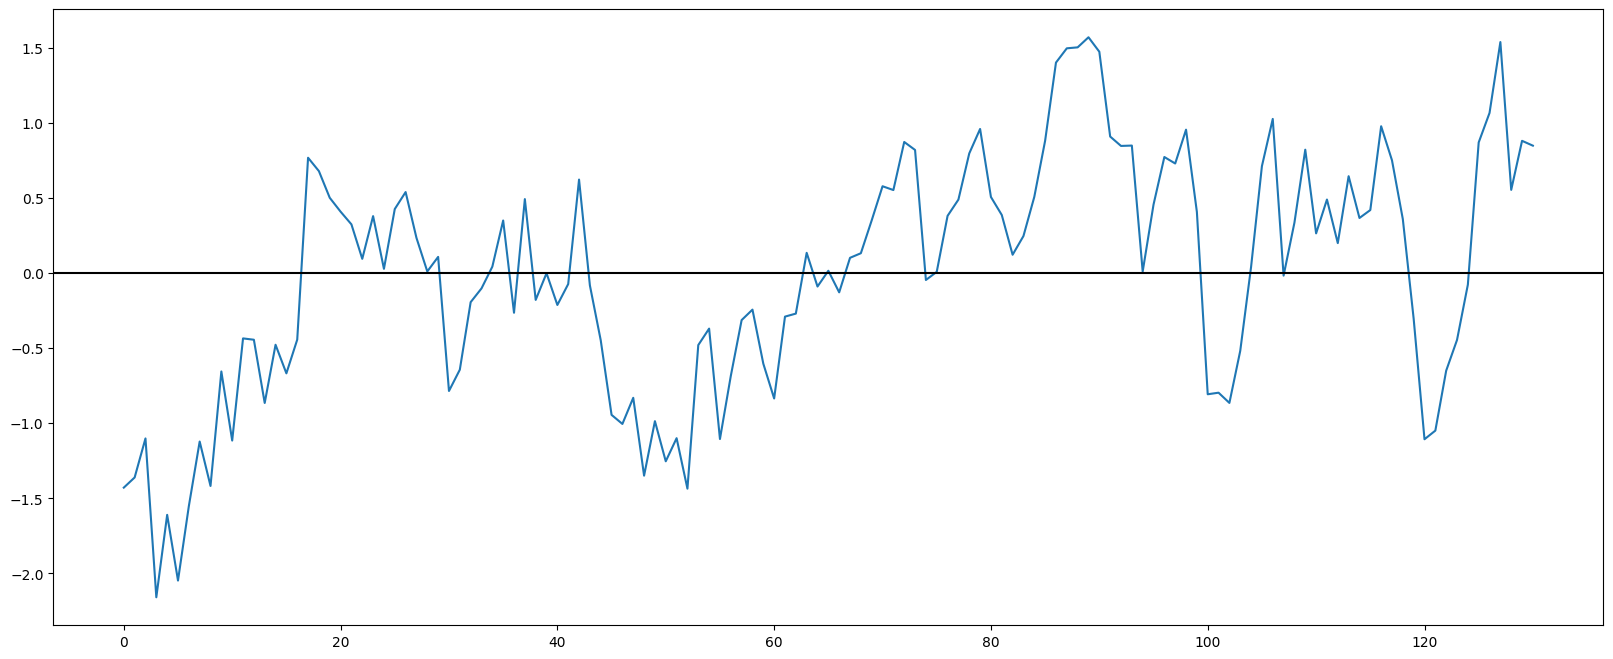

In [125]:
# Plot the spread
# STOCK1 - STOCK2 * hedge ratio


series_1 = df[asset_1].values.astype(float)
series_2 = df[asset_2].values.astype(float)
coint_flag , hedge_ratio = calc_cointergration(series_1 , series_2)


spread = series_1 - (hedge_ratio * series_2)
plt.figure(1 , figsize=(20,8))
plt.plot(spread)
plt.axhline(0, color='black') 
plt.show()


# Z Score
- how tight the band relating these two stocks is getting
- The z-score is a measure of how many standard deviations an element is from the mean.

In [126]:
# calculate z-score
window = 100 
spread_series = pd.Series(spread)
mean = spread_series.rolling(center=False,window=window).mean()
std = spread_series.rolling(center=False,window=window).std()
x = spread_series.rolling(center=False,window=1).mean()


z_score = (x - mean ) / std

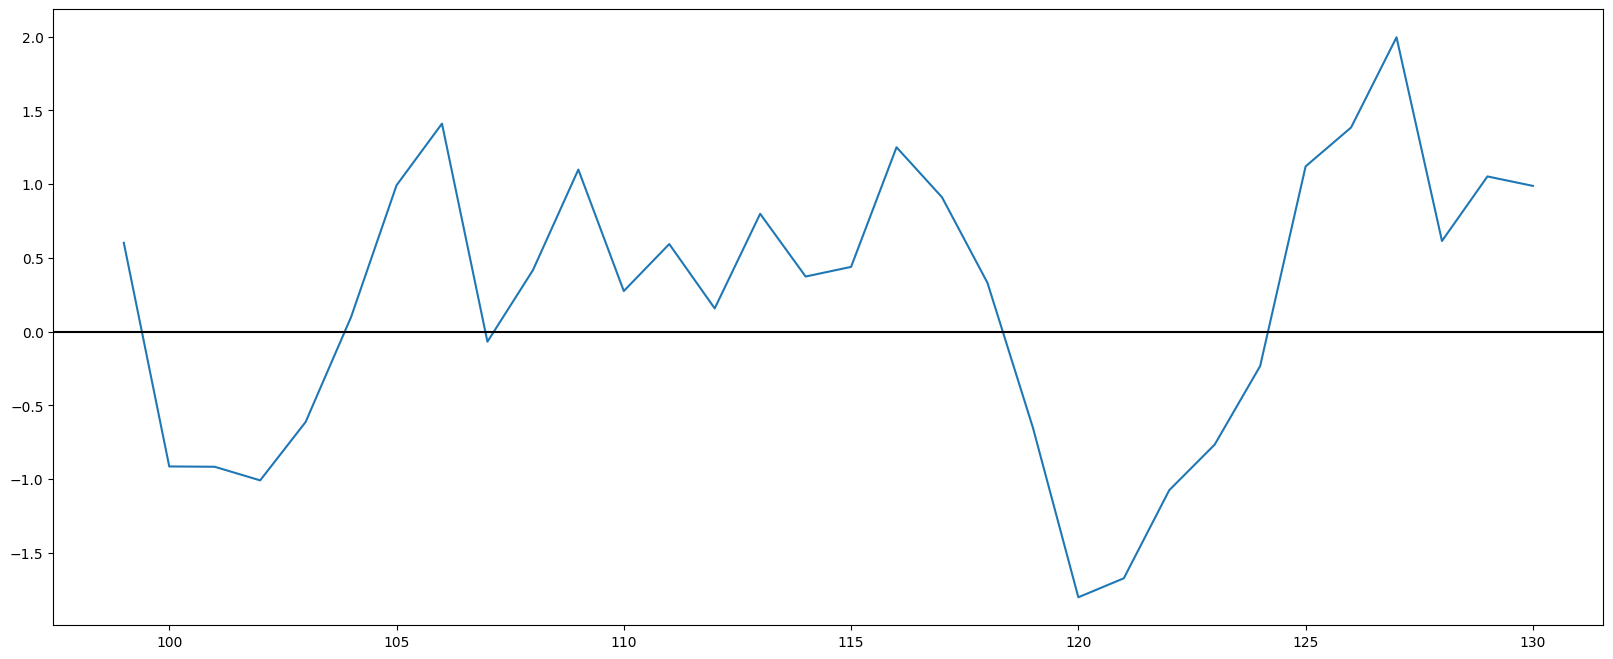

In [128]:
# Display z-score
plt.figure(1 , figsize=(20,8))
plt.plot(z_score)
plt.axhline(0, color='black') 
plt.show()